In [148]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

In [149]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )


In [150]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color=(0, 255, 255)):
    # 复制图像以避免修改原始图像
    image_temp = image.copy()

    # 检查是否是灰度图像并转换为BGR颜色空间
    if len(image_temp.shape) == 2:  # 如果图像只有高度和宽度，则为灰度图像
        image_temp = cv2.cvtColor(image_temp, cv2.COLOR_GRAY2BGR)

    # 绘制点
    for (x, y) in zip(x_point, y_point):
        cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

In [151]:
def my_fun_circle(parameters, x_samples, y_samples):
    x_c, y_c, r = parameters
    distance_to_center = np.sqrt((x_samples - x_c) ** 2 + (y_samples - y_c) ** 2)
    return distance_to_center - r

def fit_circle(x_samples, y_samples):
    initial_guess = [np.mean(x_samples), np.mean(y_samples), np.sqrt((x_samples[0] - np.mean(x_samples))**2 + (y_samples[0] - np.mean(y_samples))**2)]
    result = least_squares(my_fun_circle, initial_guess, args=(x_samples, y_samples))
    x_c, y_c, r = result.x
    return x_c, y_c, r

def Point_in_circle(x, y, r, theta):
    x_point = x + r * np.cos(theta)
    y_point = y + r * np.sin(theta)
    return x_point, y_point

In [152]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [153]:
def save_cv_image_with_plt(cv_image, output_path):
    # 如果图像是彩色的，则将其从BGR转换为RGB
    if len(cv_image.shape) == 3:
        rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv_image  # 灰度图像不需要转换

    # 创建一个新的图形，并关闭坐标轴
    plt.figure()
    plt.axis('off')  # 关闭坐标轴
    plt.gca().set_axis_off()  # 隐藏边框

    # 显示图像
    plt.imshow(rgb_image, cmap='gray' if len(cv_image.shape) == 2 else None)

    # 保存图像到文件，bbox_inches='tight' 和 pad_inches=0 用来去掉边缘空白
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()  # 关闭当前图形以释放内存

In [154]:
# 使用单应矩阵 对点进行转换
# 图像坐标系
def transform_point_with_H(x_point, y_point, H):
    point = np.array([x_point, y_point], dtype=np.float32).T
    projected_points = (cv2.perspectiveTransform(point.reshape(-1,1,2), H).reshape(-1,2).T)
    return projected_points[0], projected_points[1]


def warp_image_and_points_with_H(H, img2, x_point, y_point):
    # 获取img2的尺寸
    height, width = img2.shape[:2]

    # 定义img2四个角点的位置
    corners = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)

    # 使用perspectiveTransform来找到四个角点变换后的位置
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # 找到变换后的最小外接矩形
    x_min = min(transformed_corners[:, 0, 0])
    y_min = min(transformed_corners[:, 0, 1])
    x_max = max(transformed_corners[:, 0, 0])
    y_max = max(transformed_corners[:, 0, 1])

    # 计算新图像的宽度和高度
    new_width = int(np.round(x_max - x_min))
    new_height = int(np.round(y_max - y_min))

    # 调整H矩阵，使得变换后的图像不被裁剪
    translation_matrix = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    adjusted_H = np.dot(translation_matrix, H)

    # 应用透视变换到图像
    warped_img2 = cv2.warpPerspective(img2, adjusted_H, (new_width, new_height))

    # 将输入的点转换为正确的格式，并应用相同的变换矩阵
    points = np.array([x_point, y_point], dtype=np.float32).T.reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(points, translation_matrix).reshape(-1, 2).T
    # 返回变换后的图像和点集
    return warped_img2, transformed_points[0], transformed_points[1]


In [155]:
def cross(x1, y1, x2, y2):
    return x1 * y2 - x2 * y1

def dot(x1, y1, x2, y2):
    return x1 * x2 + y1 * y2

def mask_in_circle(img, x, y, r):
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_center = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    circle_mask = dist_from_center <= r
    return circle_mask

def crop_with_mask(img, mask, x0, y0, crop=True):
    # Apply the mask to the image
    img_masked = img.copy()

    if img.ndim == 3:
        img_masked[~mask] = [0, 0, 0]
    else :
        img_masked[~mask] = 0

    if not crop: return img_masked

    # Find bounding box of the non-zero elements in the masked image
    rows = np.any(img_masked, axis=1)
    cols = np.any(img_masked, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Crop the image using the bounding box
    cropped_img = img_masked[ymin:ymax+1, xmin:xmax+1]

    # Calculate new center coordinates relative to the cropped image
    new_x0 = x0 - xmin
    new_y0 = y0 - ymin

    return cropped_img, new_x0, new_y0

In [156]:
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot

def create_arc_mask(img, x, y, radius, s_point, t_point):

    x1, y1 = s_point
    x2, y2 = t_point
    Y, X = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')
    dist_from_center = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    circle_mask = dist_from_center <= radius

    vector_s_x, vector_s_y = x1 - x, y1 - y
    vector_t_x, vector_t_y = x2 - x, y2 - y
    vectors_x, vectors_y = X - x, Y - y

    # 往外扩展 防止边界情况
    vector_s_x, vector_s_y = rotate(vector_s_x, vector_s_y, np.radians(-3))
    vector_t_x, vector_t_y = rotate(vector_t_x, vector_t_y, np.radians(3))

    # 计算与起点向量的叉积 (vector_s, vectors)
    cross_s = cross(vector_s_x, vector_s_y, vectors_x, vectors_y)

    # 计算与终点向量的叉积 (vector_t, vectors)
    cross_t = cross(vector_t_x, vector_t_y, vectors_x, vectors_y)

    if cross(vector_s_x, vector_s_y, vector_t_x, vector_t_y) >= 0:
        return circle_mask & ((cross_s >= 0) & (cross_t <= 0))

    return circle_mask & ((cross_s >= 0) | (cross_t <= 0))


In [157]:
def black_hat(image, kernel_size=(50, 50)):

    # 定义结构元素
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # 执行黑帽运算
    blackhat_image = cv2.morphologyEx(image.copy(), cv2.MORPH_BLACKHAT, kernel)

    return blackhat_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl_img = clahe.apply(img.copy())
    return cl_img

In [158]:
def get_scan_zone_mask(img, x0, y0, xp, yp, alpha, scan_zone_r):
    # 生成与 img 相同大小的掩码
    alpha = np.radians(alpha)
    mask = np.zeros_like(img, dtype=bool)

    # 生成网格，这里 X 对应列，Y 对应行
    Y, X = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]), indexing='ij')

    X_shifted = X - x0
    Y_shifted = Y - y0

    # 计算圆形掩码
    round_mask = X_shifted ** 2 + Y_shifted ** 2 <= scan_zone_r ** 2

    # 限制点到圆形范围后再计算
    X_shifted = X_shifted[round_mask]
    Y_shifted = Y_shifted[round_mask]

    # 计算旋转后的点
    xp1, yp1 = rotate(xp - x0, yp - y0, alpha)
    xp2, yp2 = rotate(xp - x0, yp - y0, -alpha)

    # 计算向量 (x0, y0) -> (xp1, yp1) 和 (x0, y0) -> (xp2, yp2)
    v1_x, v1_y = xp1, yp1
    v2_x, v2_y = xp2, yp2

    # 计算交叉乘积
    cross_prod1 = cross(v1_x, v1_y, X_shifted, Y_shifted)
    cross_prod2 = cross(v2_x, v2_y, X_shifted, Y_shifted)
    reversed_cross_prod1 = cross(-v1_x, -v1_y, X_shifted, Y_shifted)
    reversed_cross_prod2 = cross(-v2_x, -v2_y, X_shifted, Y_shifted)

    # 创建角度区域掩码
    angle_mask = (reversed_cross_prod1 >= 0) & (reversed_cross_prod2 <= 0) | (cross_prod1 >= 0) & (cross_prod2 <= 0)

    # 合并掩码，更新原始的 mask
    mask[round_mask] = angle_mask

    return mask

In [162]:
def main(test_path,  source_path):
    config_file_path = os.path.join(source_path, 'config.yaml')

    (
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
    ) = load_specific_config(config_file_path)

    img1 = cv2.imread(image_path)
    img2 = cv2.imread(test_path)

    # 标注点检查
    candidate_point = np.array(candidate_point)
    candidate_point = np.vstack((candidate_point, zone_point))

    x_samples = candidate_point.T[0]
    y_samples = candidate_point.T[1]

    # print('标注点检查 debug')
    # show_point(img1, x_samples, y_samples)

    # 对待测图进行矫正 将标注点标注在新的图像上
    ## 求解单应矩阵
    H_img2_img1 = SIFT4H(img2, img1, True)

    ## 对图像、标注点进行透视变化
    work_img, x_img_correct, y_img_correct = warp_image_and_points_with_H(H_img2_img1, img2, x_samples, y_samples)

    ## 分离出刻度点、指针点
    zone_point_x, zone_point_y = x_img_correct[-1], y_img_correct[-1]
    x_img_correct = x_img_correct[:-1]
    y_img_correct = y_img_correct[:-1]

    ## 检查
    print('透视变化 debug')
    show_point(work_img, x_img_correct, y_img_correct)


    # 求解表盘拟合圆
    x0, y0, r0 = fit_circle(x_img_correct, y_img_correct)

    ## debug 检查
    print('拟合圆检查 debug ')
    theta_res = np.linspace(0, 2*np.pi, 200)
    x_debug, y_debug = Point_in_circle(x0, y0, r0, theta_res)
    show_point(work_img, x_debug, y_debug)

    # 求出指针扫描环型区域
    zone_point_vec = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0]) # zone -> center

    s_zone = np.linalg.norm(zone_point_vec)/r0 # 根据向量长度求出缩放因子
    r_zone = r0 * s_zone

    s_l = np.maximum(0.0, (r_zone-zone_radius-2) / r0)
    s_r = np.minimum(1.0, (r_zone+zone_radius+2) / r0)

    ## debug 扫描区域可视化
    print('debug 扫描区域可视化')
    x_zone_l, y_zone_l = Point_in_circle(x0, y0, r0 * s_l, theta_res)
    x_zone_r, y_zone_r = Point_in_circle(x0, y0, r0 * s_r, theta_res)
    show_point(work_img, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

    # 切割表盘区域
    ## 标注刻度点的极角
    theta_img_correct = np.arctan2(y_img_correct - y0, x_img_correct - x0)
    work_img_with_masked, x0, y0 = crop_with_mask(work_img, mask_in_circle(work_img, x0, y0, r0), x0, y0)

    print('debug 切割表盘区域')
    x_small_correct, y_small_correct = Point_in_circle(x0, y0, r0, theta_img_correct)
    show_point(work_img_with_masked, x_small_correct, y_small_correct)

    # 转化为灰度图
    gray_img = cv2.cvtColor(work_img_with_masked, cv2.COLOR_BGR2GRAY)

    # 切割ROI环型区域
    s_point = (x_small_correct[0], y_small_correct[0])
    t_point = (x_small_correct[-1], y_small_correct[-1])
    arc_mask = create_arc_mask(gray_img, x0, y0, r0, s_point, t_point)

    mask_inside = ~mask_in_circle(gray_img,  x0, y0, r0 * s_l)
    mask_outside = mask_in_circle(gray_img,  x0, y0, r0 * s_r)
    test_img = crop_with_mask(gray_img.copy(),  arc_mask & mask_inside & mask_outside , x0, y0, crop=False)

    # 自适应直方图均衡化 加大对比度
    test_img = apply_clahe(test_img)

    show_img(test_img)
    # 双边滤波 保护边缘的噪音去除
    test_img = cv2.bilateralFilter(test_img, d=5, sigmaColor=75, sigmaSpace=75)

    show_img(test_img)
    # 黑帽运算
    test_img = black_hat(test_img)
    show_img(test_img)

    # 指针扫描
    scan_zone_img = test_img.copy()
    show_img(scan_zone_img)

    scan_debug_img = work_img_with_masked.copy()
    output_res, max_pixel_value_mean, res_mask = None, 0, None
    res_x, res_y = None, None

    # 扫描每一个标注点的区块
    for i in range( len(x_small_correct) - 1 ):

        s_point_x, s_point_y = x_small_correct[i], y_small_correct[i]
        t_point_x, t_point_y = x_small_correct[i + 1], y_small_correct[i + 1]

        # # 两个相邻标点不应该超过90度
        theta_s = np.arctan2(s_point_y - y0, s_point_x - x0)
        theta_t = np.arctan2(t_point_y - y0, t_point_x - x0)

        # 响邻点角度差不能超过90
        while np.abs(theta_t - theta_s) > np.pi:
            if theta_s < theta_t: theta_s += np.pi * 2
            else: theta_t += np.pi * 2

        # 切分出step * 10 + 1个点
        theta_small_point = np.linspace(theta_s, theta_t, step * 10 + 1)
        x_small, y_small = Point_in_circle(x0, y0, r0 * s_zone, theta_small_point)


        # 若整个矩形内没有白色像素就不需要检索
        min_x = max(0, int(x_small.min()))
        max_x = min(scan_zone_img.shape[0], int(x_small.max()))
        min_y = max(0, int(y_small.min()))
        max_y = min(scan_zone_img.shape[1], int(y_small.max()))
        if scan_zone_img[min_y:max_y+1, min_x:max_x+1].sum() < max_pixel_value_mean : continue

        L_res = ((END_POINT - START_POINT) / (len(x_small_correct) - 1)) * i + START_POINT
        R_res = ((END_POINT - START_POINT) / (len(x_small_correct) - 1)) * (i + 1) + START_POINT

        # print(L_res, R_res)
        for j, (xp, yp) in enumerate(zip(x_small, y_small)):
            scan_zone_mask = get_scan_zone_mask(scan_zone_img, xp, yp, x0, y0, zone_theta, zone_radius)
            # scan_debug_img[scan_zone_mask] = 0

            if np.any(scan_zone_mask): pixel_value_mean = scan_zone_img[scan_zone_mask].mean()
            else: pixel_value_mean = 0

            pixel_res = L_res + (R_res-L_res) / (step * 10) * j

            if max_pixel_value_mean < pixel_value_mean:
                max_pixel_value_mean = pixel_value_mean
                output_res = pixel_res
                res_x, res_y = xp, yp
                res_mask = scan_zone_mask

        # if output_res is not None:
        #     scan_debug_img[res_mask] = 0

    print('finish')

    if output_res is not None:
        scan_debug_img[res_mask] = 0
        print(output_res)
        print(f'res = {output_res:.{PRESICISION}f}{UNIT}')
        show_img(scan_debug_img)
    else: print('failed')

In [160]:
# test_path = 'source/1.1/img/tv20171227162937UVG250.jpg'
# test_path = 'source/1.2/img/tv20171227163039JZAH8I.jpg'
# test_path = 'source/1.3/img/59.jpg'
# test_path = 'source/1.4/img/template.png'
# test_path = 'source/2.1/img/010a39586359164fd9f26ecadb888f2.jpg'

source_path = 'source/1.4/'
# main(test_path, source_path)

source/1.4/img/Snipaste_2025-01-12_02-30-03.jpg


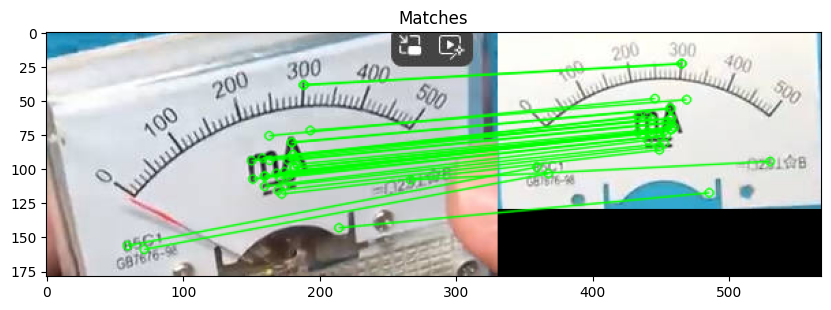

透视变化 debug


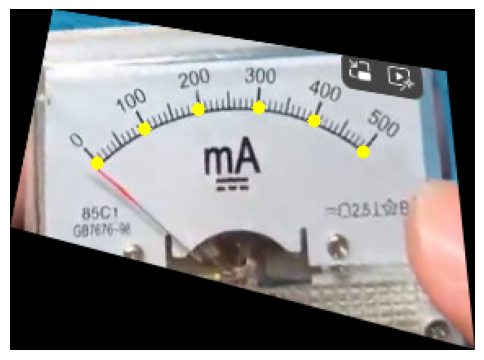

拟合圆检查 debug 


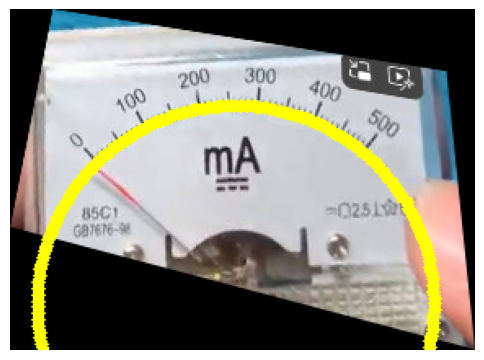

debug 扫描区域可视化


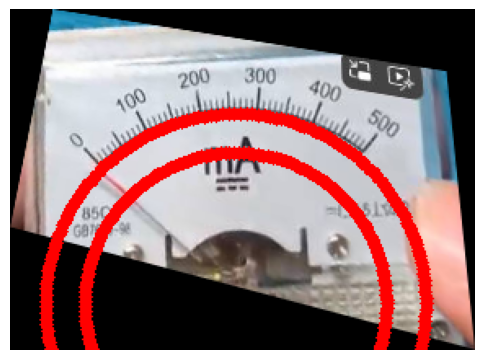

debug 切割表盘区域


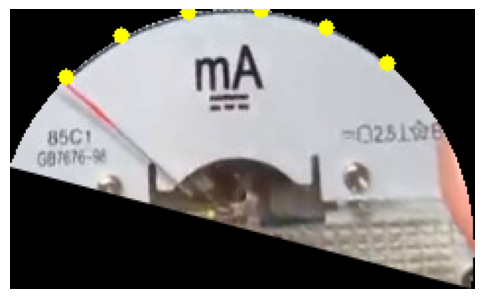

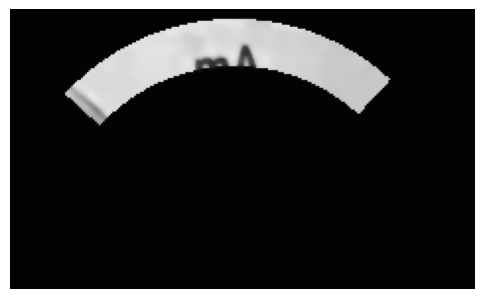

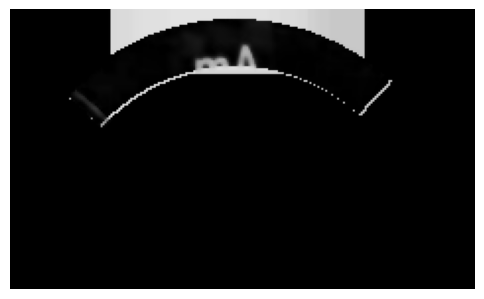

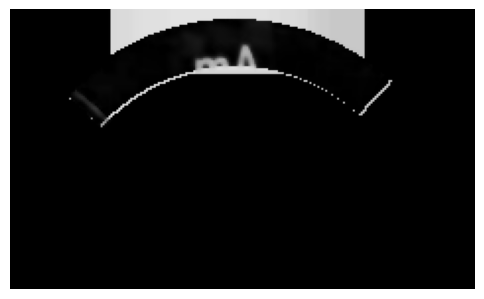

finish
285.0
res = 285ma


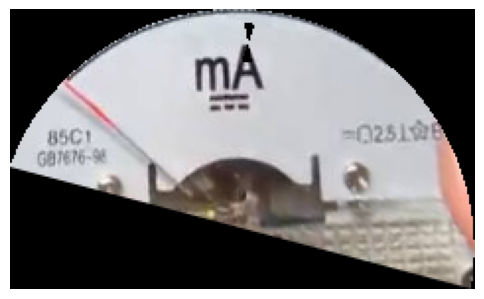

In [161]:
import os

def get_files(directory):
    # 遍历指定目录, 返回一个包含文件完整路径的列表 (不包括子目录)
    files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files

# 获取文件路径列表
directory_path = os.path.join(source_path, 'img')  # 替换为你的目录路径
file_list = get_files(directory_path)

for file in file_list:
    print(file)
    main(file, source_path)
    break